<a href="https://colab.research.google.com/github/ahmdeltoky03/Pneumonia-Detection-Xray/blob/main/code/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:24<00:00, 202MB/s]
100% 2.29G/2.29G [00:24<00:00, 102MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip -d chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train

In [ ]:
import os
import shutil
import random
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import skimage
import skimage.segmentation
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
labels = ['PNEUMONIA','NORMAL']
image_size = 128

def remove_ds_store(data_dir):
    """
    Removes any files ending with .DS_Store in the directory.
    """

    for label in labels:
        images_path = os.path.join(data_dir, label)
        for img in os.listdir(images_path):
            if img.endswith('.DS_Store'):
                img_path = os.path.join(images_path, img)
                os.remove(img_path)  # Remove the .DS_Store file
                print(f"Removed: {img_path}")



def get_data(data_dir):
  data = []
  remove_ds_store(data_dir)


  for label in labels:
    images_path = os.path.join(data_dir,label)
    class_data = labels.index(label)

    for img in os.listdir(images_path):

        img_path = os.path.join(images_path,img)

        if img_path.endswith('.DS_Store'):
          continue

        try:
          img_array = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)

          if img_array is not None:
            resized_img_array = cv2.resize(img_array,(image_size,image_size))
            data.append([resized_img_array,class_data])
          else:
            print(f"Failed To Read This Image : {img_path}")


        except Exception as e:
          print(e)

  return data

In [ ]:
train_data = get_data('chest_xray/chest_xray/train')
test_data = get_data('chest_xray/chest_xray/test')
validation_data = get_data('chest_xray/chest_xray/val')

In [ ]:
pneumonia = os.listdir('chest_xray/chest_xray/train/PNEUMONIA')
pneumonia_dir = "chest_xray/chest_xray/train/PNEUMONIA"

normal = os.listdir('chest_xray/chest_xray/train/NORMAL')
normal_dir = "chest_xray/chest_xray/train/NORMAL"

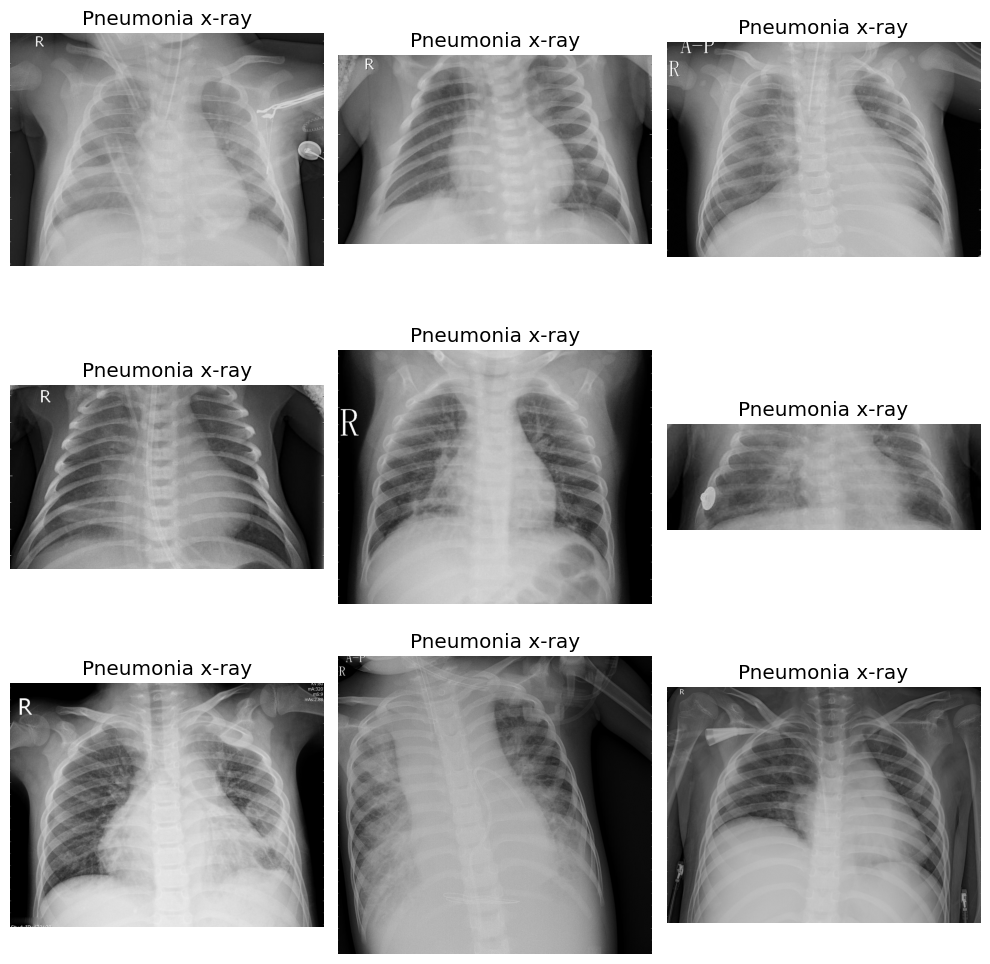

In [ ]:
plt.figure(figsize=(10,10))

for i in range(9):
  plt.subplot(3,3,i+1)
  img = plt.imread(os.path.join(pneumonia_dir,pneumonia[i]))
  plt.imshow(img,cmap='gray')
  plt.title('Pneumonia x-ray')
  plt.axis('off')
plt.tight_layout()
plt.show()

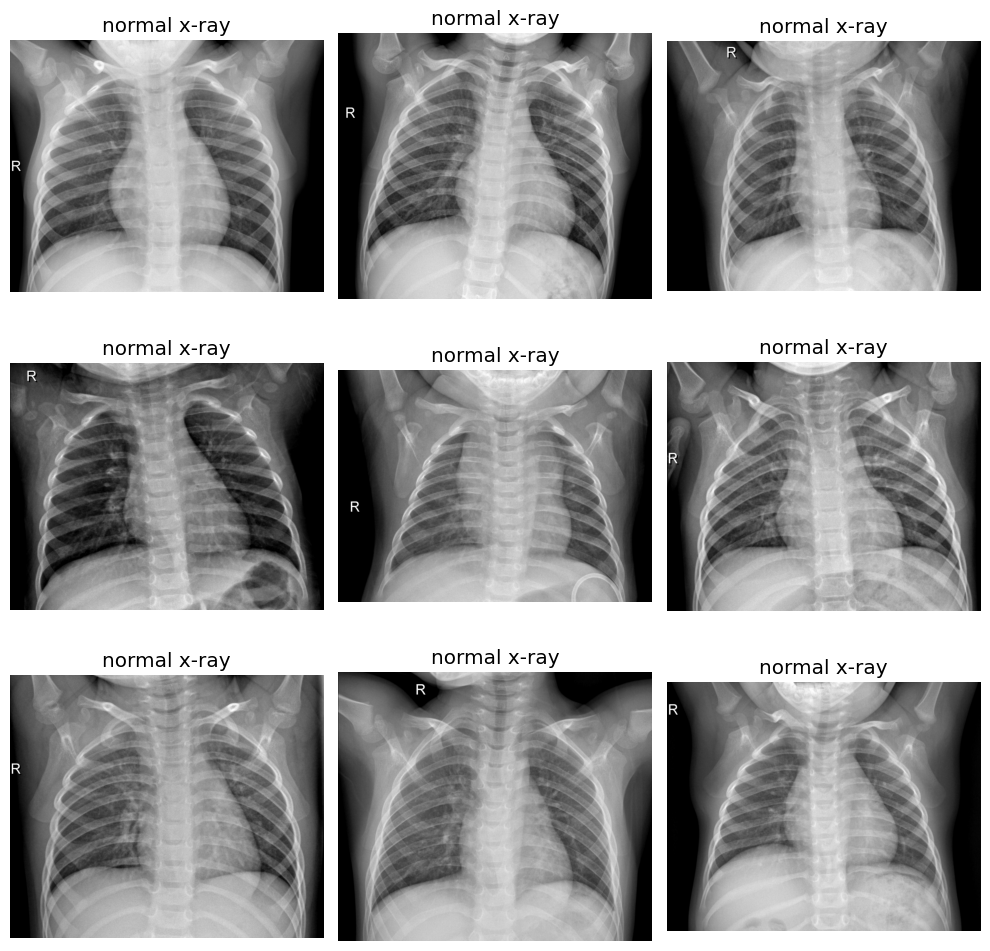

In [ ]:
plt.figure(figsize=(10,10))

for i in range(9):
  plt.subplot(3,3,i+1)
  img = plt.imread(os.path.join(normal_dir,normal[i]))
  plt.imshow(img,cmap='gray')
  plt.title('normal x-ray')
  plt.axis('off')
plt.tight_layout()
plt.show()

Train Data : 
Pneumonia Cases:  3875
Normal Cases:  1341

Test Data : 
Pneumonia Cases:  390
Normal Cases:  234

Validation Data : 
Pneumonia Cases:  8
Normal Cases:  8



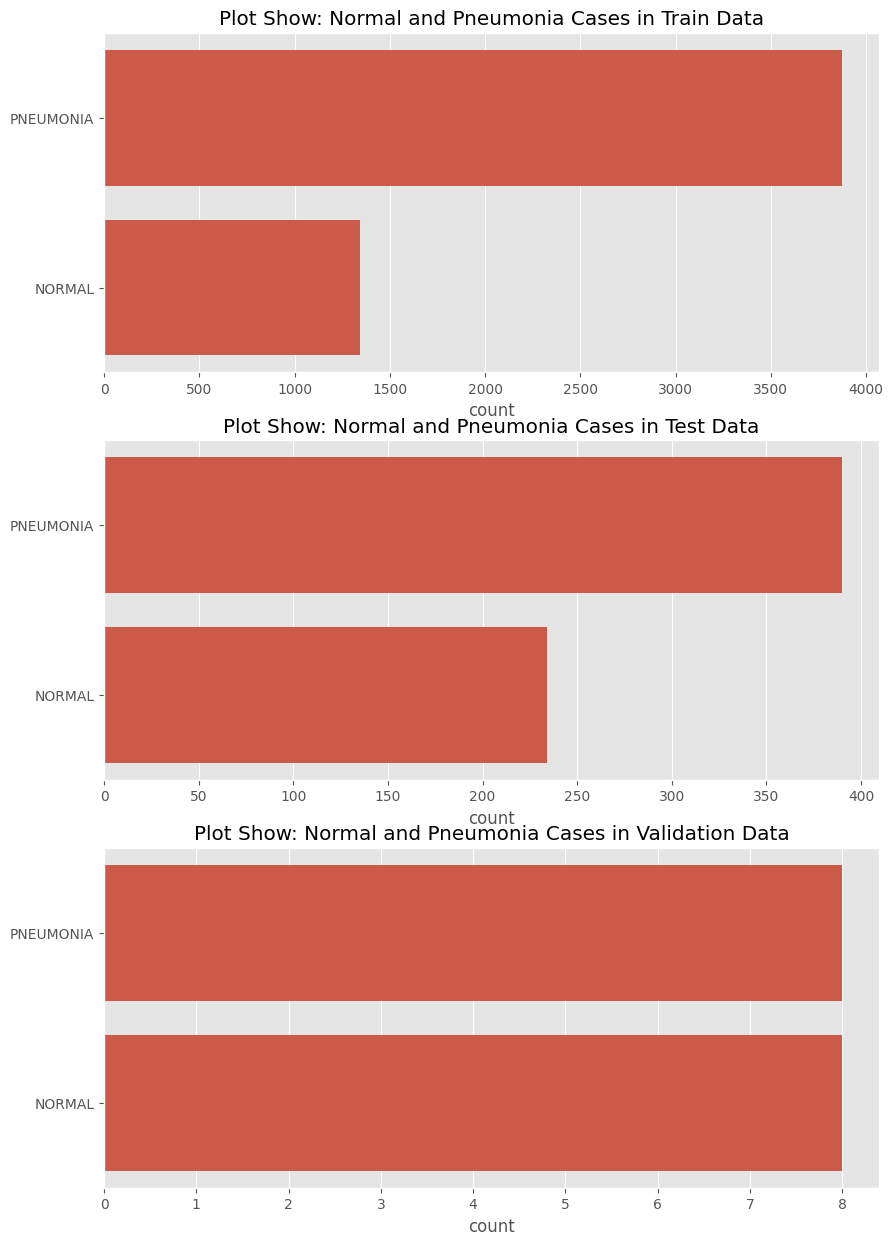

In [ ]:
plt.figure(figsize=(10, 15))

datasets = [
    ("Train Data", train_data),
    ("Test Data", test_data),
    ("Validation Data", validation_data)
]


for i,(title,data) in enumerate(datasets,start=1):
  _list = ["PNEUMONIA" if i[1]==0 else "NORMAL" for i in data]

  print(f'{title} : ')
  print('Pneumonia Cases: ',_list.count('PNEUMONIA'))
  print('Normal Cases: ',_list.count('NORMAL'))
  print()

  plt.subplot(3,1,i)
  sns.countplot(_list)
  plt.title(f'Plot Show: Normal and Pneumonia Cases in {title}')






In [ ]:
# Data Augmentation & Resizing

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input,Dense,Flatten,MaxPooling2D,Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=.4,
                                   vertical_flip=.4,
                                   rotation_range=40,
                                   shear_range=.2,
                                   width_shift_range=.4,
                                   height_shift_range=.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory('chest_xray/chest_xray/train',
                                  batch_size=32,
                                  target_size=(image_size, image_size),
                                  shuffle=True,
                                  class_mode='categorical',
                                  color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory('chest_xray/chest_xray/val',
                                  batch_size=32,
                                  target_size=(image_size, image_size),
                                  shuffle=True,
                                  class_mode='categorical',
                                  color_mode='rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
labels = train_generator.class_indices
labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
class_name = {val:key for key,val in labels.items()}
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [ ]:
#VGG19 CNN Architecture
from tensorflow.keras.applications import VGG19
base_model  = VGG19(input_shape=(image_size,image_size,3),
    include_top=False,
    weights='imagenet')

# to avoid weight updates
for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
dropout = Dropout(.2)(class_1)
class_2 = Dense(1152, activation='relu')(dropout)

output = Dense(2,activation='softmax')(class_2)

model_01 = Model(base_model.inputs,output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
filepath = 'model.h5'
es = EarlyStopping(monitor='val_loss',verbose=1,mode='min',patience=4)
cp = ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=True,
                     save_weights_only=False,mode='auto',save_freq='epoch')
rop = ReduceLROnPlateau(monitor='val_accuracy',patience=3,min_lr=.0001,verbose=1,factor=.5)
sgd = SGD(learning_rate=.001,momentum=.0,decay=1e-6)

model_01.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history_01 = model_01.fit(train_generator,
             steps_per_epoch=50,
             epochs=1,
             callbacks=[es,cp,rop],
             validation_data=valid_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7455 - loss: 0.5653
Epoch 1: val_loss improved from inf to 0.59822, saving model to model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 452s 9s/step - accuracy: 0.7453 - loss: 0.5649 - val_accuracy: 0.6875 - val_loss: 0.5982 - learning_rate: 0.0010


In [ ]:
if not os.path.isdir('model_weights/'):
  os.mkdir('model_weights/')
model_01.save(filepath = 'model_weights/vgg19_model_01.h5',overwrite=True)

In [ ]:
test_generator = test_datagen.flow_from_directory('chest_xray/chest_xray/test',
                                  batch_size=32,
                                  target_size=(image_size, image_size),
                                  shuffle=True,
                                  class_mode='categorical',
                                  color_mode='rgb')

Found 624 images belonging to 2 classes.


In [ ]:
model_01.load_weights('model_weights/vgg19_model_01.h5')

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.6875 - loss: 0.5982
20/20 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step - accuracy: 0.7654 - loss: 0.5871


In [ ]:
print(f'Validation Loss : {vgg_val_eval_01[0]}')
print(f'Validation accuracy : {vgg_val_eval_01[1]}')

print(f'Test Loss : {vgg_test_eval_01[0]}')
print(f'Test accuracy : {vgg_test_eval_01[1]}')

Validation Loss : 0.5982164144515991
Validation accuracy : 0.6875
Test Loss : 0.5893345475196838
Test accuracy : 0.7628205418586731


In [ ]:
# Fine Tuning

In [ ]:
base_model = VGG19(input_shape=(image_size,image_size,3),
                   include_top=False)
base_model_layer_name = [layer.name for layer in base_model.layers]
# base_model_layer_name

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
dropout = Dropout(.2)(class_1)
class_2 = Dense(1152, activation='relu')(dropout)

output = Dense(2,activation='softmax')(class_2)


model_02 = Model(base_model.inputs,output)
model_02.load_weights('model_weights/vgg19_model_01.h5')

set_trainable = False
for layer in base_model.layers:
  if layer.name in ['block5_conv3','block5_conv4']:
    set_trainable = True
  if set_trainable:
    set_trainalbe = True
  else:
    set_trainable = False

print(model_02.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
base_model_layer_name

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [ ]:
sgd = SGD(learning_rate=.0001,momentum=.0,decay=1e-6)
model_02.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [ ]:
history_02 = model_02.fit(train_generator,
             steps_per_epoch=10,
             epochs=1,
             callbacks=[es,cp,rop],
             validation_data=valid_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_27']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.7159 - loss: 0.5322 
Epoch 1: val_loss did not improve from 0.59822
10/10 ━━━━━━━━━━━━━━━━━━━━ 307s 30s/step - accuracy: 0.7170 - loss: 0.5323 - val_accuracy: 0.6250 - val_loss: 0.6220 - learning_rate: 1.0000e-04


In [ ]:
if not os.path.isdir('model_weights/'):
  os.mkdir('model_weights/')
model_02.save(filepath = 'model_weights/vgg19_model_02.h5',overwrite=True)

In [ ]:
model_02.load_weights('model_weights/vgg19_model_02.h5')

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f'Validation Loss : {vgg_val_eval_02[0]}')
print(f'Validation accuracy : {vgg_val_eval_02[1]}')

print(f'Test Loss : {vgg_test_eval_02[0]}')
print(f'Test accuracy : {vgg_test_eval_02[1]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6250 - loss: 0.6220
20/20 ━━━━━━━━━━━━━━━━━━━━ 167s 8s/step - accuracy: 0.7203 - loss: 0.5758
Validation Loss : 0.6220003366470337
Validation accuracy : 0.625
Test Loss : 0.5748944878578186
Test accuracy : 0.7147436141967773


In [ ]:
# unfreezing and fine tunnig the entire network

In [ ]:
base_model = VGG19(input_shape=(image_size,image_size,3),
                   include_top=False)

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
dropout = Dropout(.2)(class_1)
class_2 = Dense(1152, activation='relu')(dropout)

output = Dense(2,activation='softmax')(class_2)


model_03 = Model(base_model.inputs,output)
model_03.load_weights('model_weights/vgg19_model_01.h5')

print(model_03.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
sgd = SGD(learning_rate=.0001,momentum=.0,decay=1e-6,nesterov=True)
model_03.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [ ]:
history_03 = model_02.fit(train_generator,
             steps_per_epoch=50,
             epochs=1,
             callbacks=[es,cp,rop],
             validation_data=valid_generator)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.7879 - loss: 0.4620 
Epoch 1: val_loss did not improve from 0.59822
50/50 ━━━━━━━━━━━━━━━━━━━━ 1503s 30s/step - accuracy: 0.7877 - loss: 0.4622 - val_accuracy: 0.6250 - val_loss: 0.6020 - learning_rate: 1.0000e-04


In [ ]:
if not os.path.isdir('model_weights/'):
  os.mkdir('model_weights/')
model_03.save(filepath = 'model_weights/vgg19_model_03.h5',overwrite=True)

In [ ]:
model_03.load_weights('model_weights/vgg19_model_03.h5')

vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print(f'Validation Loss : {vgg_val_eval_03[0]}')
print(f'Validation accuracy : {vgg_val_eval_03[1]}')

print(f'Test Loss : {vgg_test_eval_03[0]}')
print(f'Test accuracy : {vgg_test_eval_03[1]}')

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_54']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6875 - loss: 0.5982
20/20 ━━━━━━━━━━━━━━━━━━━━ 164s 8s/step - accuracy: 0.7637 - loss: 0.5876
Validation Loss : 0.5982164144515991
Validation accuracy : 0.6875
Test Loss : 0.5893346071243286
Test accuracy : 0.7628205418586731


# Test Model

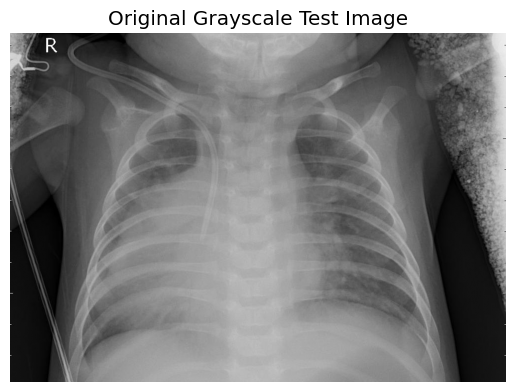

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Predicted class: pneumonia


In [ ]:
image_size = 128

# Path to the test image
test_img_path = '/content/chest_xray/chest_xray/test/PNEUMONIA/person95_bacteria_463.jpeg'

# Load test image in grayscale
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)

# Display the original grayscale image
plt.imshow(test_img, cmap='gray')
plt.title('Original Grayscale Test Image')
plt.axis('off')
plt.show()

# Resize image to expected dimensions
test_img = cv2.resize(test_img, (image_size, image_size))
test_img_color = cv2.cvtColor(test_img, cv2.COLOR_GRAY2BGR)
test_img_input = np.expand_dims(test_img_color, axis=0)
model_03 = load_model('model_weights/vgg19_model_03.h5')
predictions = model_03.predict(test_img_input)
predicted_class = np.argmax(predictions, axis=1)[0]
predicted_class = "pneumonia" if predicted_class == 0 else "normal"

print("Predicted class:", predicted_class)


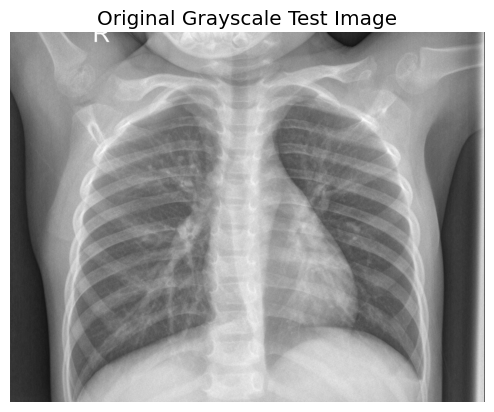

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
Predicted class: normal


In [ ]:
image_size = 128

# Path to the test image
test_img_path = '/content/chest_xray/chest_xray/test/NORMAL/IM-0009-0001.jpeg'
# Load test image in grayscale
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)

# Display the original grayscale image
plt.imshow(test_img, cmap='gray')
plt.title('Original Grayscale Test Image')
plt.axis('off')
plt.show()

# Resize image to expected dimensions
test_img = cv2.resize(test_img, (image_size, image_size))
test_img_color = cv2.cvtColor(test_img, cv2.COLOR_GRAY2BGR)
test_img_input = np.expand_dims(test_img_color, axis=0)
model_03 = load_model('model_weights/vgg19_model_03.h5')
predictions = model_03.predict(test_img_input)
predicted_class = np.argmax(predictions, axis=1)[0]
predicted_class = "pneumonia" if predicted_class == 0 else "normal"

print("Predicted class:", predicted_class)

# Thank You